# Embeddings using HF

In [8]:
import torch as t
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import numpy as np
from pprint import pprint

In [3]:
chkpoint = "openai/clip-vit-base-patch16"
model = AutoModel.from_pretrained(chkpoint)
processor = AutoImageProcessor.from_pretrained(chkpoint)
tokenizer = AutoTokenizer.from_pretrained(chkpoint)

In [4]:
from datasets import load_dataset

In [5]:
ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id'],
        num_rows: 2340
    })
    validation: Dataset({
        features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id'],
        num_rows: 130
    })
    test: Dataset({
        features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id'],
        num_rows: 131
    })
})

Each element of the training set is a dict which contains the image as an Image object along with some other metadata

In [6]:
trainset = ds["train"]

In [10]:
print(type(trainset[0]))
trainset[0].keys()

<class 'dict'>


dict_keys(['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id'])

In [26]:
for key, value in trainset[0].items():
    print("\n{0}:\n{1}".format(key, value))
    


image:
<PIL.JpegImagePlugin.JpegImageFile image mode=L size=400x288 at 0x7EB44F999010>

contest_number:
130

image_location:
the yard

image_description:
Two women are looking out a window. There is snow outside, and there is a snowman with human arms.

image_uncanny_description:
A snowman has branches for arms, not human arms.

entities:
['https://en.wikipedia.org/wiki/Snowman', 'https://en.wikipedia.org/wiki/Human']

questions:
['Is there a man stuck inside?']

caption_choices:
He has a summer job as a scarecrow.

from_description:
scene: the yard description: Two women are looking out a window. There is snow outside, and there is a snowman with human arms. uncanny: A snowman has branches for arms, not human arms. entities: Snowman, Human. caption: He has a summer job as a scarecrow.

label:
The real man inside of the snowman is apparently the sort of person who will take a seasonal job as a seasonally-appropriate anthropomorphic sculpture, e.g., a snowman in winter, or a scarecrow 

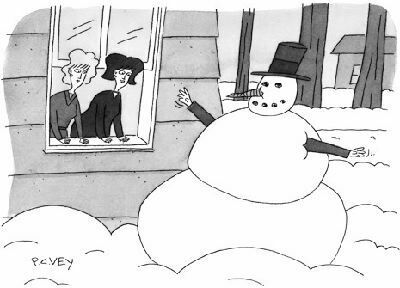

In [28]:
img = trainset[0]["image"]
img

## Image Embeddings
To get the embeddings of an image, tensorize it and give it to the model. The `processor` is used to tensorize the image. It outputs a dict with a single key `pixel_values` which is a $[N, C, H, W]$ PyTorch tensor.

In [29]:
img_tensor = processor(img, return_tensors="pt")
print(type(img_tensor))
print(img_tensor.keys())
img_tensor["pixel_values"].shape

<class 'transformers.image_processing_base.BatchFeature'>
dict_keys(['pixel_values'])


torch.Size([1, 3, 224, 224])

In [30]:
img_emb = model.get_image_features(pixel_values=img_tensor["pixel_values"])
print(type(img_emb))
img_emb.shape

<class 'torch.Tensor'>


torch.Size([1, 512])

PG Vector supports only numpy input, so this tensor needs to be convered. Moreover, it does not support batched embeddings, so this need to be made into a single array.

In [31]:
img_emb = img_emb.detach().squeeze().numpy()
img_emb.shape

(512,)

## Text Embeddings
To get the embeddings of a piece of text, tokenize it and give it to the model. The `tokenizer` is used to tokenize the image. It outputs a dict with a single key `input_ids` which is a $[N, 10]$ PyTorch tensor.

In [33]:
txt = "This is a multimodal retrieval demo"
txt_toks = tokenizer([txt], truncation=True, return_tensors="pt")
print(type(txt_toks))
print(txt_toks.keys())
txt_toks["input_ids"].shape

<class 'transformers.tokenization_utils_base.BatchEncoding'>
dict_keys(['input_ids', 'attention_mask'])


torch.Size([1, 10])

In [34]:
txt_emb = model.get_text_features(input_ids=txt_toks["input_ids"])
txt_emb.shape

torch.Size([1, 512])